# CS445: Term Project

#### Victor Weeks & Josh Lutz

## Introduction

## Data

In [1]:
from gw2spidy import Gw2Spidy as spidy # allows retrieval of market information
import numpy as np
import json
import random
import neuralnetworksA4 as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
itemIDs = (19718,19720,19697,19680,19719,19738,19723,19710,
           19739,19740,19699,19683,19703,19687,19728,19733,19726,19713,
           19741,19742,19698,19682,19730,19734,19727,19714,
           19743,19744,19702,19686,19731,19736,19736,19724,19711,
           19748,19747,19700,19684,19729,19735,19722,19709,
           19745,19746,19701,19685,19732,19737,19725,19712)

In [3]:
itemTimeData = np.load('itemData.npy')
itemTimeData.shape

(13362, 13)

In [4]:
names = ['item_id', 'max_offer_price', 'min_sale_price', 'offer_availability', 'sale_availability', 'sale_price_change', 'offer_price_change', 'year', 'month', 'day', 'hour', 'minute', 'second']

In [20]:
Xnames = names[1:7]
Tnames = names[1:7]

In [54]:
def makeItemData(itemID=19718, allItems=False, splitData=False, stepsAheadToPredict=4):
    itemTimeData = np.load('itemData.npy')
    if allItems:
        itemData = np.mean(itemTimeData[0:50], axis=0).reshape((1,-1))
        for bucket in itemTimeData[51::51]:
            itemData = np.vstack((itemData, np.mean(bucket.reshape((1,-1)), axis=0).reshape((1,-1))))
    else:
        itemData = itemTimeData[np.where(itemTimeData[:]==itemID)[0]]
    X = itemData[:-stepsAheadToPredict, 1:7].copy()
    T = itemData[stepsAheadToPredict:, 1:7].copy()
    if splitData:
        rows = np.arange(X.shape[0])
        nTrain = int(X.shape[0] * 0.7)
        Xtrain = X[rows[:nTrain],:]
        Ttrain = T[rows[:nTrain],:]
        Xtest = X[rows[nTrain:],:]
        Ttest = T[rows[nTrain:],:]
        return Xtrain, Ttrain, Xtest, Ttest
    else:        
        return X, T, itemData

Note: Had to make sure to copy the X and T data because of how the Time-Embedded data is accessed.

In [55]:
Xtrain, Ttrain, items = makeItemData(allItems=True) # training with all items
Xtest, Ttest, item1 = makeItemData(19718)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((260, 6), (260, 6), (260, 6), (260, 6))

In [50]:
Xtrain, Ttrain, Xtest, Ttest = makeItemData(19718, splitData=True, stepsAheadToPredict=8)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((179, 6), (179, 6), (77, 6), (77, 6))

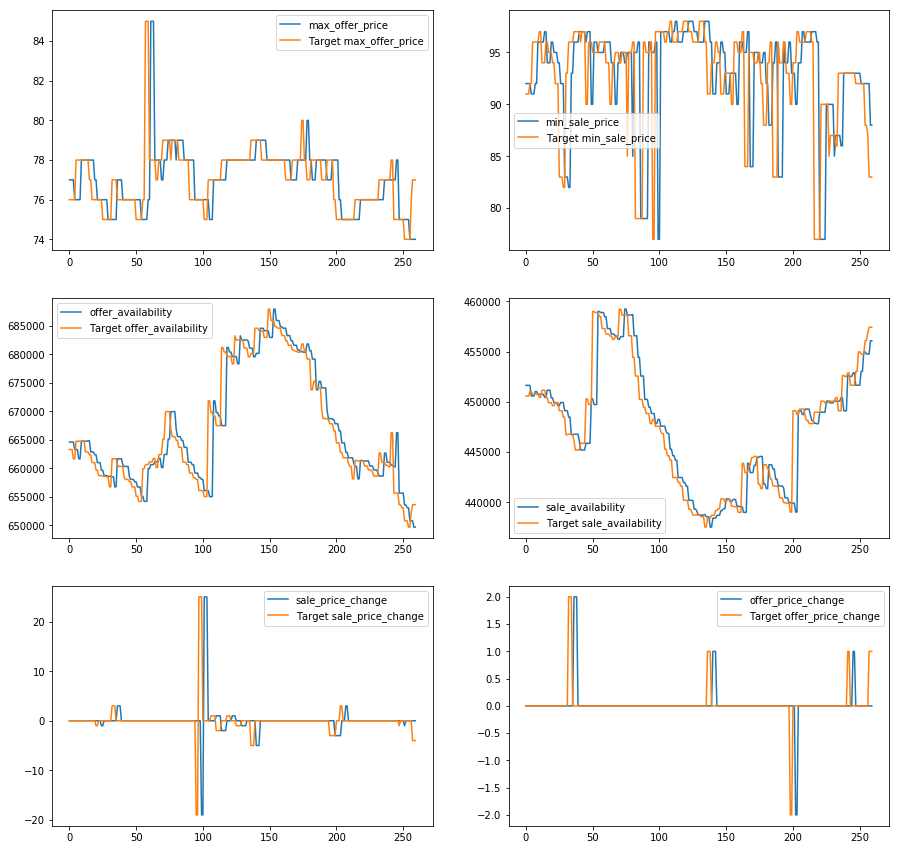

In [57]:
fig = plt.figure(figsize=(15,15))

plt.subplot(3,2,1)
plt.plot(Xtest[:,0], label=Xnames[0])
plt.plot(Ttest[:,0], label='Target ' + Tnames[0])
plt.legend();

plt.subplot(3,2,2)
plt.plot(Xtest[:,1], label=Xnames[1])
plt.plot(Ttest[:,1], label='Target ' + Tnames[1])
plt.legend();

plt.subplot(3,2,3)
plt.plot(Xtest[:,2], label=Xnames[2])
plt.plot(Ttest[:,2], label='Target ' + Tnames[2])
plt.legend();

plt.subplot(3,2,4)
plt.plot(Xtest[:,3], label=Xnames[3])
plt.plot(Ttest[:,3], label='Target ' + Tnames[3])
plt.legend();

plt.subplot(3,2,5)
plt.plot(Xtest[:,4], label=Xnames[4])
plt.plot(Ttest[:,4], label='Target ' + Tnames[4])
plt.legend();

plt.subplot(3,2,6)
plt.plot(Xtest[:,5], label=Xnames[5])
plt.plot(Ttest[:,5], label='Target ' + Tnames[5])
plt.legend();

## Methods

### Time-Embedding

In [15]:
def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

In [32]:
def rollingWindows(X, windowSize=4):    
    nSamples, nAttributes = X.shape
    nWindows = nSamples - windowSize + 1
    # Shape of resulting matrix
    newShape = (nWindows, nAttributes * windowSize)
    itemSize = X.itemsize  # number of bytes
    # Number of bytes to increment to starting element in each dimension
    strides = (nAttributes * itemSize, itemSize)
    return np.lib.stride_tricks.as_strided(X, shape=newShape, strides=strides)

In [58]:
XtrainW = rollingWindows(Xtrain, windowSize=9)
XtestW = rollingWindows(Xtest, windowSize=9)
TtrainW = Ttrain[:XtrainW.shape[0]]
TtestW = Ttest[:XtestW.shape[0]]
XtrainW.shape, TtrainW.shape, XtestW.shape, TtestW.shape

((252, 54), (252, 6), (252, 54), (252, 6))

In [18]:
import pandas as pd
def getBestAvgNeuralStructure(Xtrain,Xtest,Ttrain,Ttest,nIterations=1000,timesToAvg=5,plot=False):
    errors = []
    hiddens = [0] + [[nu] * nl for nu in [1, 5, 10, 20, 50] for nl in [1, 2, 3, 4, 5]]
    for hids in hiddens:
        errorTrain = 0
        errorTest = 0
        errorAvg = 0
        for _ in range(timesToAvg):
            nnet = nn.NeuralNetwork(Xtrain.shape[1], hids, Ttrain.shape[1])
            nnet.train(Xtrain, Ttrain, nIterations)
            errorTrain += rmse(Ttrain, nnet.use(Xtrain))
            errorTest += rmse(Ttest, nnet.use(Xtest))
            errorAvg = (errorTrain + errorTest)/2
        errors.append([hids,errorTrain/timesToAvg,errorTest/timesToAvg,errorAvg/timesToAvg])
    errors = pd.DataFrame(errors)
    print(errors)
    if plot==True:
        plt.figure(figsize=(10, 10))
        plt.plot(errors.values[:, 1:], 'o-')
        plt.title('RMSE Values for Neural Net')
        plt.legend(('Train', 'Test', 'Avg Error'))
        plt.xticks(range(errors.shape[0]), hiddens, rotation=30, horizontalalignment='right')
        plt.grid(True)
    minErrorAverage = errors[3].min()
    minIndex = list(errors[3]).index(minErrorAverage)
    bestHids = errors[0][minIndex]
    print('Lowest average error over',timesToAvg,'fully trained iterations:',bestHids,'with error:',minErrorAverage)
    return bestHids

In [ ]:
getBestAvgNeuralStructure(XtrainW,XtestW,TtrainW,TtestW,2000,5,True)

SCG: Iteration 200 fValue Eval 0.00230464630936 Scale 1e-15
SCG: Iteration 400 fValue Eval 0.000490344765247 Scale 1e-15
SCG: Iteration 600 fValue Eval 0.000258149987952 Scale 1e-15
SCG: Iteration 800 fValue Eval 0.00016887055836 Scale 1e-15
SCG: Iteration 1000 fValue Eval 0.000128557250647 Scale 1e-15
SCG: Iteration 1200 fValue Eval 8.55701096328e-05 Scale 1e-15
SCG: Iteration 1400 fValue Eval 7.10537212793e-05 Scale 1e-15
SCG: Iteration 1600 fValue Eval 6.06714150669e-05 Scale 1e-15
SCG: Iteration 1800 fValue Eval 5.56762785794e-05 Scale 1e-15
SCG: Iteration 2000 fValue Eval 5.09098551213e-05 Scale 1e-15
NeuralNetwork(54, [10, 10, 10], 6)
   Network was trained for 2001 iterations that took 6.9580 seconds. Final error is 0.007135114233236887.


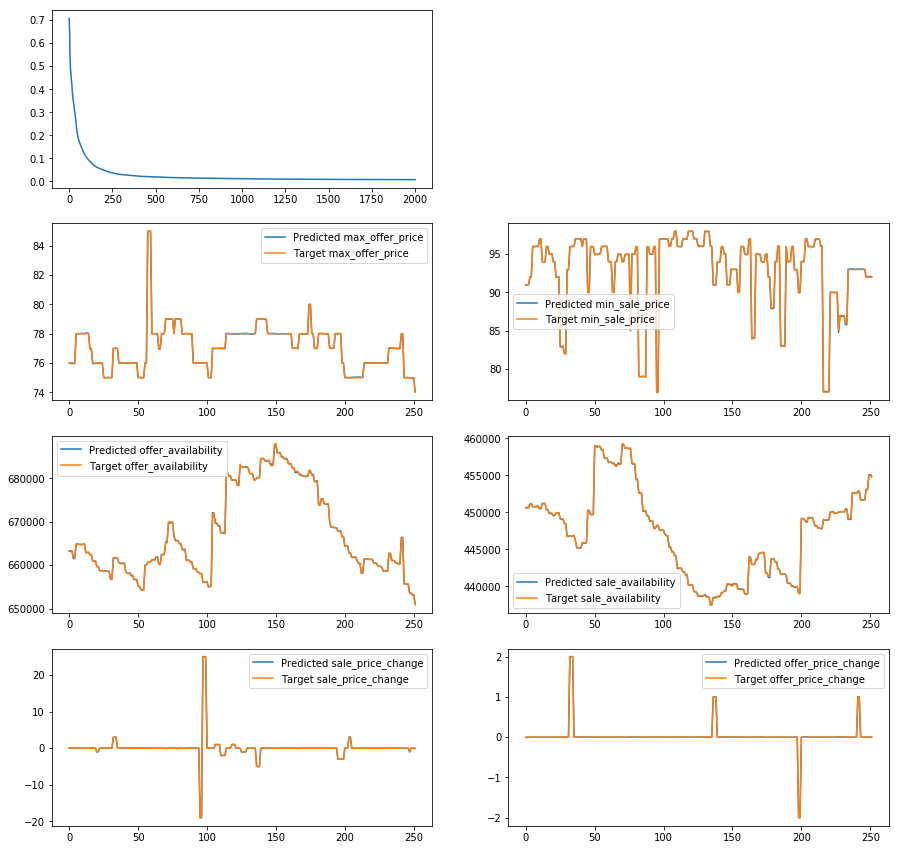

In [59]:
nnet = nn.NeuralNetwork(XtrainW.shape[1], [10,10,10], TtrainW.shape[1])
nnet.train(XtrainW, TtrainW, 2000, verbose=True)

fig = plt.figure(figsize=(15,15))
plt.subplot(4,2,1)
plt.plot(nnet.getErrors())
print(nnet)

Y = nnet.use(XtestW)
plt.subplot(4,2,3)
plt.plot(Y[:,0], label='Predicted ' + Tnames[0])
plt.plot(TtestW[:,0], label='Target ' + Tnames[0])
plt.legend();

plt.subplot(4,2,4)
plt.plot(Y[:,1], label='Predicted ' + Tnames[1])
plt.plot(TtestW[:,1], label='Target ' + Tnames[1])
plt.legend();

plt.subplot(4,2,5)
plt.plot(Y[:,2], label='Predicted ' + Tnames[2])
plt.plot(TtestW[:,2], label='Target ' + Tnames[2])
plt.legend();

plt.subplot(4,2,6)
plt.plot(Y[:,3], label='Predicted ' + Tnames[3])
plt.plot(TtestW[:,3], label='Target ' + Tnames[3])
plt.legend();

plt.subplot(4,2,7)
plt.plot(Y[:,4], label='Predicted ' + Tnames[4])
plt.plot(TtestW[:,4], label='Target ' + Tnames[4])
plt.legend();

plt.subplot(4,2,8)
plt.plot(Y[:,5], label='Predicted ' + Tnames[5])
plt.plot(TtestW[:,5], label='Target ' + Tnames[5])
plt.legend();

## Results

For some reason, giving a window size of 1 timepoint larger than the steps ahead to predict gives best accuracy

## Conclusions

## References

## Word Count

In [1340]:
import io
from IPython.nbformat import current
import glob
nbfile = glob.glob('TermProject.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file TermProject.ipynb is 63
